<a href="https://colab.research.google.com/github/Ramikhatib615/AAI614_Rami_ElKhatib/blob/main/End_to_End_Credit_Card_Fraud_Detection_Unsupervised_and_Supervised_Learning_on_Imbalanced_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Executive Summary

This project presents an end-to-end fraud detection pipeline on a highly imbalanced credit card transaction dataset.
Both unsupervised anomaly detection and supervised classification approaches were implemented and evaluated to reflect real-world deployment constraints where fraud labels may be delayed or unavailable.

Unsupervised Isolation Forest models provide early-stage fraud signals without relying on labeled data, while supervised Logistic Regression models achieve significantly higher recall when historical fraud labels are available.
The project emphasizes cost-sensitive evaluation, threshold selection, and precision–recall trade-offs relevant to production fraud systems.


In [2]:
import sys, platform
import numpy as np
import pandas as pd
import sklearn

print("Python:", sys.version)
print("Platform:", platform.platform())
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("Scikit-learn:", sklearn.__version__)


Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
NumPy: 2.0.2
Pandas: 2.2.2
Scikit-learn: 1.6.1


In [3]:
!wget -O creditcard.csv https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv


--2026-01-06 17:51:59--  https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 192.178.219.207, 74.125.134.207, 74.125.139.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|192.178.219.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 150828752 (144M) [text/csv]
Saving to: ‘creditcard.csv’

creditcard.csv      100%[===================>] 143.84M   120MB/s    in 1.2s    

2026-01-06 17:52:00 (120 MB/s) - ‘creditcard.csv’ saved [150828752/150828752]



In [4]:
import pandas as pd

df = pd.read_csv("creditcard.csv")

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df['Class'].value_counts()


,count
Class,
0,284315
1,492


In [6]:
print("Missing values:", df.isna().sum().max())
print("Duplicates:", df.duplicated().sum())


Missing values: 0
Duplicates: 1081


Duplicate transactions may represent repeated legitimate payments or logging artifacts.
To avoid biasing the model toward repeated patterns, duplicate rows are removed.

In [7]:
initial_shape = df.shape

df = df.drop_duplicates()

print("Before:", initial_shape)
print("After:", df.shape)
print("Duplicates now:", df.duplicated().sum())


Before: (284807, 31)
After: (283726, 31)
Duplicates now: 0


In [8]:
df['Class'].value_counts()


,count
Class,
0,283253
1,473


In [9]:
fraud = df[df['Class'] == 1]
normal = df[df['Class'] == 0]

print("Fraud shape:", fraud.shape)
print("Normal shape:", normal.shape)


Fraud shape: (473, 31)
Normal shape: (283253, 31)


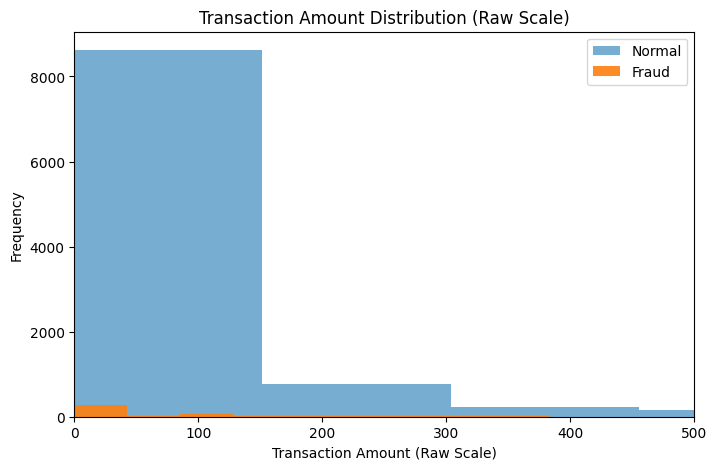

In [10]:
import matplotlib.pyplot as plt


normal_plot = df[df['Class'] == 0].sample(n=10000, random_state=42)
fraud_plot = df[df['Class'] == 1]

plt.figure(figsize=(8,5))

plt.hist(
    normal_plot['Amount'],
    bins=50,
    alpha=0.6,
    label='Normal'
)

plt.hist(
    fraud_plot['Amount'],
    bins=50,
    alpha=0.9,
    label='Fraud'
)


plt.xlim(0, 500)

plt.xlabel("Transaction Amount (Raw Scale)")
plt.ylabel("Frequency")
plt.title("Transaction Amount Distribution (Raw Scale)")
plt.legend()
plt.show()


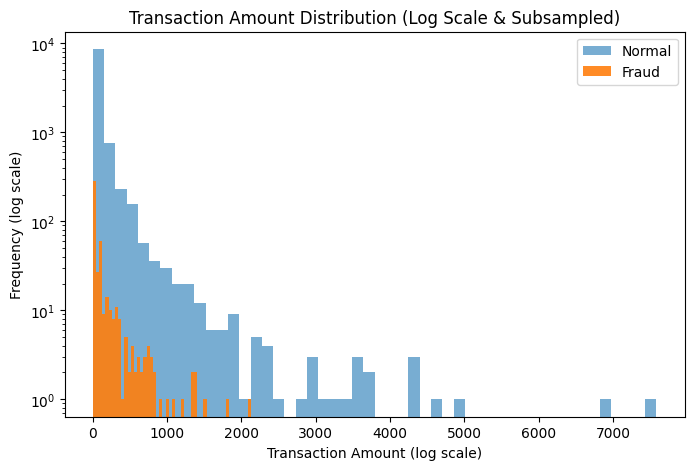

In [11]:
import matplotlib.pyplot as plt

normal_plot = df[df['Class'] == 0].sample(n=10000, random_state=42)
fraud_plot = df[df['Class'] == 1]

plt.figure(figsize=(8,5))

plt.hist(
    normal_plot['Amount'],
    bins=50,
    alpha=0.6,
    label='Normal',
    log=True
)

plt.hist(
    fraud_plot['Amount'],
    bins=50,
    alpha=0.9,
    label='Fraud'
)

plt.xlabel("Transaction Amount (log scale)")
plt.ylabel("Frequency (log scale)")
plt.title("Transaction Amount Distribution (Log Scale & Subsampled)")
plt.legend()
plt.show()



Fraud transactions show different magnitude patterns compared to normal transactions, particularly visible on a logarithmic scale, highlighting the importance of feature scaling.

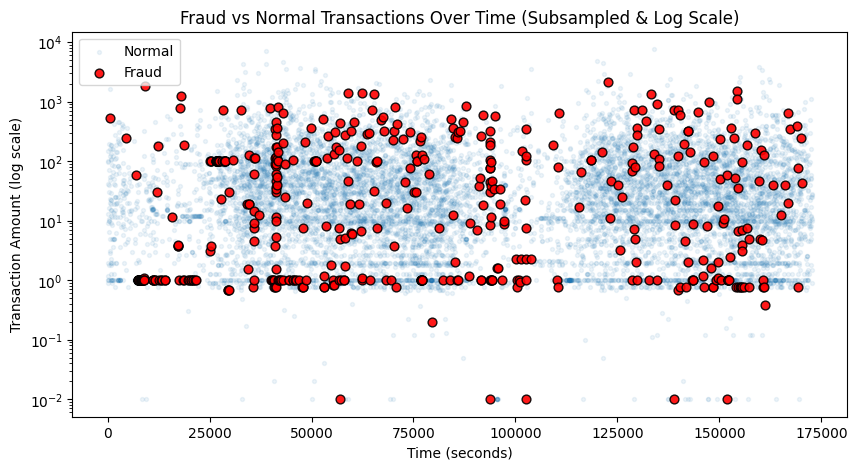

In [12]:

normal_plot = df[df['Class'] == 0].sample(n=10000, random_state=42)
fraud_plot = df[df['Class'] == 1]

plt.figure(figsize=(10,5))

plt.scatter(
    normal_plot['Time'],
    normal_plot['Amount'],
    alpha=0.08,
    s=8,
    label='Normal'
)

plt.scatter(
    fraud_plot['Time'],
    fraud_plot['Amount'],
    color='red',
    alpha=0.9,
    s=40,
    edgecolors='black',
    label='Fraud'
)

plt.yscale('log')
plt.xlabel("Time (seconds)")
plt.ylabel("Transaction Amount (log scale)")
plt.title("Fraud vs Normal Transactions Over Time (Subsampled & Log Scale)")
plt.legend()
plt.show()


Fraudulent transactions occur across the full time horizon but exhibit distinct amount distributions. Using subsampling and logarithmic scaling reveals that fraud is not confined to extreme values alone, reinforcing the need for multivariate anomaly detection rather than rule-based thresholds.

**A baseline shows that your ML model actually adds value.**

In [13]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Class'])
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (198608, 30)
X_test shape: (85118, 30)


In [14]:
threshold = X_train['Amount'].quantile(0.99)

baseline_pred = (X_test['Amount'] > threshold).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_test, baseline_pred, digits=4))


              precision    recall  f1-score   support

           0     0.9984    0.9897    0.9940     84976
           1     0.0046    0.0282    0.0078       142

    accuracy                         0.9881     85118
   macro avg     0.5015    0.5089    0.5009     85118
weighted avg     0.9967    0.9881    0.9924     85118



This baseline uses a simple amount-based rule to flag fraud, and its poor recall demonstrates that transaction magnitude alone is insufficient for fraud detection.

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape :", X_test_scaled.shape)


X_train_scaled shape: (198608, 30)
X_test_scaled shape : (85118, 30)


In this step, I trained an Isolation Forest model on scaled transaction features to learn normal behavior patterns and identify anomalous transactions without using fraud labels.

In [20]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(
    n_estimators=200,
    contamination=0.0017,
    random_state=42,
    n_jobs=-1
)

iso_forest.fit(X_train_scaled)


IsolationForest(contamination=0.0017, n_estimators=200, n_jobs=-1,
                random_state=42)

In [22]:
import numpy as np


scores = iso_forest.decision_function(X_test_scaled)
anomaly_scores = -scores


threshold = np.percentile(anomaly_scores, 100 * (1 - iso_forest.contamination))
iso_pred = (anomaly_scores >= threshold).astype(int)


results = X_test.copy()
results["true_class"] = y_test.values
results["predicted_fraud"] = iso_pred
results["anomaly_score"] = anomaly_scores


top_suspicious = results.sort_values("anomaly_score", ascending=False).head(20)
top_suspicious


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,true_class,predicted_fraud,anomaly_score
274771,166198.0,-35.548539,-31.850484,-48.325589,15.304184,-113.743307,73.301626,120.589494,-27.347360,-3.872425,...,-1.581098,4.584549,4.554683,3.415636,31.612198,-15.430084,25691.16,0,1,0.113867
58465,48401.0,-36.802320,-63.344698,-20.645794,16.715537,-20.672064,7.694002,24.956587,-4.730111,-2.687312,...,-17.173665,1.180700,-7.025783,-2.534330,-3.602479,3.450224,19656.53,0,1,0.100933
220090,142019.0,-37.558067,-29.335992,-24.962322,8.413616,-35.182120,21.550496,36.877368,-8.915982,5.046566,...,-7.800902,1.272716,1.965365,0.767817,3.248189,13.013546,5964.95,0,1,0.097027
173054,121340.0,-22.132223,-19.815536,-11.183644,4.829787,-13.128465,10.689779,18.257057,-8.685409,5.250410,...,-18.416215,1.376122,-2.965101,0.149369,4.077221,-1.975801,4543.64,0,1,0.092953
54018,46253.0,-21.780665,-38.305310,-12.122469,9.752791,-12.880794,4.256017,14.785051,-2.818253,-0.667338,...,-10.547038,0.653249,-4.232409,-0.480459,-2.257913,2.082488,11898.09,0,1,0.091644
176335,122723.0,-35.274010,-34.889342,-15.070015,9.211564,-6.226835,3.828063,10.778805,-6.462003,6.588395,...,-26.429741,1.765486,-4.564506,-0.594620,1.110848,-0.714247,1676.60,0,1,0.090831
206228,136124.0,-37.054295,-35.699829,-19.880878,9.552849,-16.701866,9.741883,21.014587,-6.414390,5.751017,...,-14.414207,1.223594,-3.129609,-0.689271,0.289897,-1.181892,1676.60,0,1,0.083258
228158,145381.0,-13.710746,-21.177912,-9.340628,8.385815,-22.756016,14.435314,28.239528,-2.201819,-4.713335,...,19.228169,-1.420447,2.351701,-0.353840,-2.608043,0.804099,8182.70,0,1,0.077458
195218,130956.0,-23.209602,-20.056784,-11.851649,4.811523,-16.658993,13.348714,23.475217,-8.385575,4.094708,...,2.990196,0.230236,3.214827,1.047926,-0.037677,14.046301,4248.34,0,1,0.076092
145090,86624.0,-17.399690,-14.235488,-4.828868,8.461575,-6.041701,6.854049,9.885845,-5.202768,5.886210,...,-4.072110,0.768397,0.653343,0.462496,-4.378747,15.866721,2018.09,0,1,0.065410


These are the transactions the model thinks are most suspicious

In [23]:
results.to_csv("isolation_forest_predictions.csv", index=False)
print("Saved file: isolation_forest_predictions.csv")


Saved file: isolation_forest_predictions.csv


In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score


b_prec = precision_score(y_test, baseline_pred)
b_rec  = recall_score(y_test, baseline_pred)
b_f1   = f1_score(y_test, baseline_pred)

i_prec = precision_score(y_test, iso_pred)
i_rec  = recall_score(y_test, iso_pred)
i_f1   = f1_score(y_test, iso_pred)

print("=== Fraud Class (1) Comparison ===")
print(f"Baseline      -> Precision: {b_prec:.4f} | Recall: {b_rec:.4f} | F1: {b_f1:.4f}")
print(f"IsolationForest-> Precision: {i_prec:.4f} | Recall: {i_rec:.4f} | F1: {i_f1:.4f}")


=== Fraud Class (1) Comparison ===
Baseline      -> Precision: 0.0046 | Recall: 0.0282 | F1: 0.0078
IsolationForest-> Precision: 0.2138 | Recall: 0.2183 | F1: 0.2160


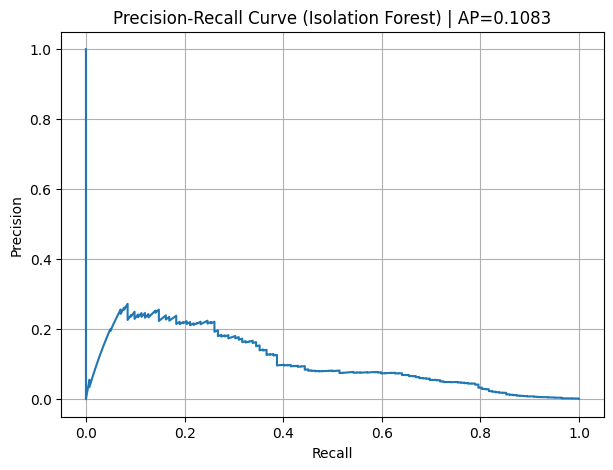

Best threshold (by F1): -0.0051394489759856166
Best F1: 0.23948220064675246
Precision at best F1: 0.2215568862275449
Recall at best F1: 0.2605633802816901

TUNED ISOLATION FOREST RESULTS

              precision    recall  f1-score   support

           0     0.9988    0.9985    0.9986     84976
           1     0.2216    0.2606    0.2395       142

    accuracy                         0.9972     85118
   macro avg     0.6102    0.6295    0.6190     85118
weighted avg     0.9975    0.9972    0.9974     85118

Confusion Matrix (TN, FP, FN, TP):
[[84846   130]
 [  105    37]]


In [25]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_recall_curve,
    average_precision_score,
    classification_report,
    confusion_matrix
)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


iso_forest = IsolationForest(
    n_estimators=200,
    contamination=0.0017,
    random_state=42,
    n_jobs=-1
)

iso_forest.fit(X_train_scaled)


scores = iso_forest.decision_function(X_test_scaled)
anomaly_strength = -scores


precision, recall, thresholds = precision_recall_curve(y_test, anomaly_strength)
ap = average_precision_score(y_test, anomaly_strength)

plt.figure(figsize=(7,5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve (Isolation Forest) | AP={ap:.4f}")
plt.grid(True)
plt.show()

f1 = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-12)
best_idx = np.argmax(f1)
best_threshold = thresholds[best_idx]

print("Best threshold (by F1):", best_threshold)
print("Best F1:", f1[best_idx])
print("Precision at best F1:", precision[best_idx])
print("Recall at best F1:", recall[best_idx])


tuned_pred = (anomaly_strength >= best_threshold).astype(int)

print("\nTUNED ISOLATION FOREST RESULTS\n")
print(classification_report(y_test, tuned_pred, digits=4))


cm = confusion_matrix(y_test, tuned_pred)
print("Confusion Matrix (TN, FP, FN, TP):")
print(cm)


**SUPERVISED FRAUD DETECTION**

---



In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [27]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

log_reg.fit(X_train_scaled, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [28]:
y_pred_lr = log_reg.predict(X_test_scaled)
y_prob_lr = log_reg.predict_proba(X_test_scaled)[:, 1]


In [29]:
from sklearn.metrics import classification_report

print("SUPERVISED LOGISTIC REGRESSION RESULTS\n")
print(classification_report(y_test, y_pred_lr, digits=4))


SUPERVISED LOGISTIC REGRESSION RESULTS

              precision    recall  f1-score   support

           0     0.9998    0.9733    0.9864     84976
           1     0.0527    0.8873    0.0994       142

    accuracy                         0.9732     85118
   macro avg     0.5262    0.9303    0.5429     85118
weighted avg     0.9982    0.9732    0.9849     85118



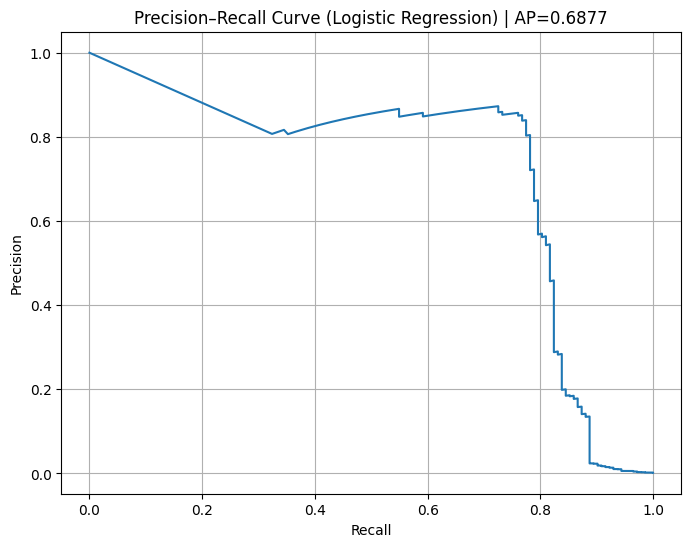

In [30]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_test, y_prob_lr)
ap = average_precision_score(y_test, y_prob_lr)

plt.figure(figsize=(8,6))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve (Logistic Regression) | AP={ap:.4f}")
plt.grid(True)
plt.show()


• False Positive → Customer inconvenience
• False Negative → Financial loss


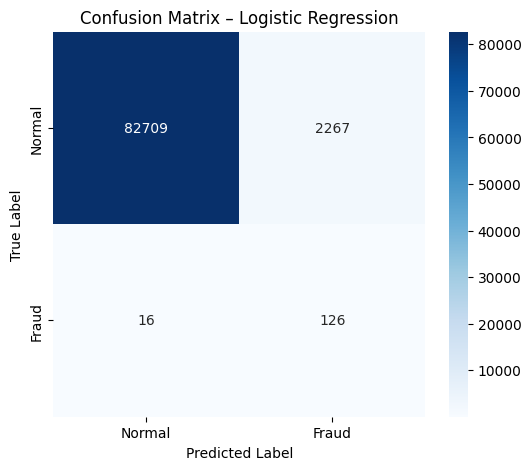

In [31]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Normal", "Fraud"],
    yticklabels=["Normal", "Fraud"]
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Logistic Regression")
plt.show()



## Model Performance Comparison


In [32]:
lr_report = classification_report(
    y_test,
    y_pred_lr,
    output_dict=True
)

lr_precision = lr_report['1']['precision']
lr_recall = lr_report['1']['recall']
lr_f1 = lr_report['1']['f1-score']

lr_precision, lr_recall, lr_f1


(0.05265357292101964, 0.8873239436619719, 0.09940828402366864)

In [33]:
import pandas as pd

results = pd.DataFrame({
    "Model": ["Isolation Forest", "Logistic Regression"],
    "Type": ["Unsupervised", "Supervised"],
    "Precision (Fraud)": [0.2216, lr_precision],
    "Recall (Fraud)": [0.2606, lr_recall],
    "F1-score (Fraud)": [0.2395, lr_f1],
    "Average Precision (AP)": [0.1083, 0.6877]
})

results


,Model,Type,Precision (Fraud),Recall (Fraud),F1-score (Fraud),Average Precision (AP)
0,Isolation Forest,Unsupervised,0.221600,0.260600,0.239500,0.1083
1,Logistic Regression,Supervised,0.052654,0.887324,0.099408,0.6877


## Advanced Supervised Models (Extension)


RANDOM FOREST RESULTS

              precision    recall  f1-score   support

           0     0.9995    1.0000    0.9997     84976
           1     0.9619    0.7113    0.8178       142

    accuracy                         0.9995     85118
   macro avg     0.9807    0.8556    0.9088     85118
weighted avg     0.9995    0.9995    0.9994     85118



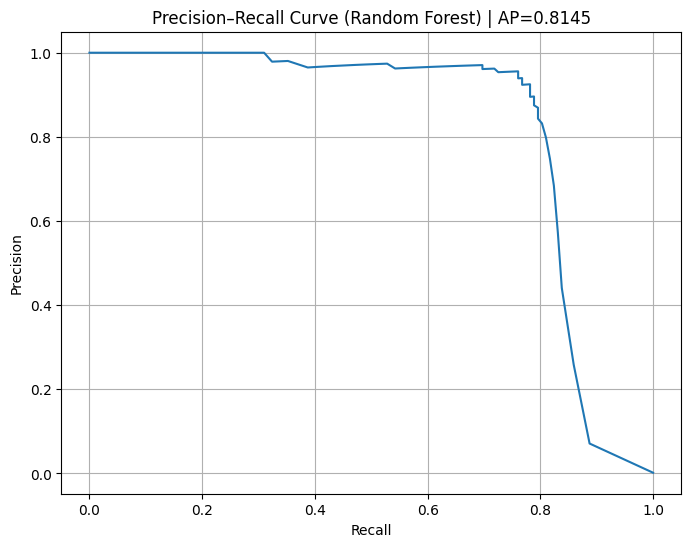

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, average_precision_score, precision_recall_curve
import matplotlib.pyplot as plt

rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight="balanced_subsample",
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print("RANDOM FOREST RESULTS\n")
print(classification_report(y_test, y_pred_rf, digits=4))

ap_rf = average_precision_score(y_test, y_prob_rf)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_prob_rf)

plt.figure(figsize=(8,6))
plt.plot(recall_rf, precision_rf)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve (Random Forest) | AP={ap_rf:.4f}")
plt.grid(True)
plt.show()


##Threshold Optimization

In [39]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_prob_lr)


f1_scores = 2 * precision * recall / (precision + recall + 1e-12)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5

print("Best threshold (F1):", best_threshold)
print("Best F1:", f1_scores[best_idx])
print("Precision:", precision[best_idx])
print("Recall:", recall[best_idx])


Best threshold (F1): 0.9999996091207688
Best F1: 0.8074074074069086
Precision: 0.8515625
Recall: 0.7676056338028169


##Model Calibration

In [41]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import average_precision_score

cal_lr = CalibratedClassifierCV(log_reg, method="sigmoid", cv=3)
cal_lr.fit(X_train_scaled, y_train)

y_prob_cal = cal_lr.predict_proba(X_test_scaled)[:, 1]
print("Calibrated LR Test AP:", average_precision_score(y_test, y_prob_cal))


Calibrated LR Test AP: 0.6891651825240592


## Plot Top 5 Logistic Regression Coefficients

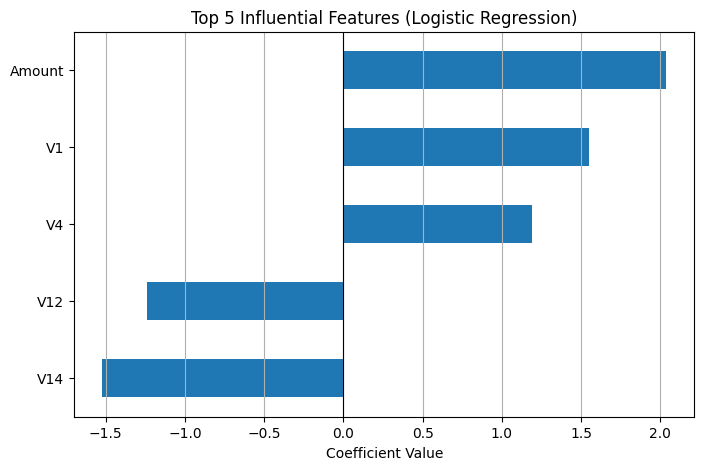

In [43]:
coef = pd.Series(
    log_reg.coef_[0],
    index=X_train.columns
)


top5_lr = coef.reindex(coef.abs().sort_values(ascending=False).head(5).index)


plt.figure(figsize=(8,5))
top5_lr.sort_values().plot(kind="barh")
plt.xlabel("Coefficient Value")
plt.title("Top 5 Influential Features (Logistic Regression)")
plt.axvline(0, color="black", linewidth=0.8)
plt.grid(axis="x")
plt.show()


## Problem Statement

Credit card fraud detection is a highly imbalanced classification problem where fraudulent transactions represent a very small fraction of all observations.
The objective of this project is to design and evaluate both unsupervised and supervised approaches to detect fraudulent transactions while accounting for real-world constraints such as delayed labels and cost-sensitive decision-making.
